In [2]:
#import xgboost as xgb
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from scipy.stats import spearmanr
import matplotlib.pyplot as plt


In [3]:
def load_hyperparams(filename):
    hyperparams = {}
    with open(filename, 'r') as f:
        for line in f:
            key, value = line.strip().split(': ')
            try:
                value = float(value) if '.' in value else int(value)
            except ValueError:
                pass  
            hyperparams[key] = value
    return hyperparams


In [4]:
best_hyperparams = load_hyperparams('best_hyperparams_v3.txt')
best_hyperparams

{'lambda': 0.13544951561665153,
 'alpha': 0.0010181835507502832,
 'subsample': 0.7885676744065945,
 'colsample_bytree': 0.7090337807050557,
 'max_depth': 4,
 'learning_rate': 0.12136026483574651,
 'n_estimators': 75}

In [11]:
modelTrainingPath = "../Data/modelTraining/"
train_df = pd.read_csv(f'{modelTrainingPath}trainData.csv')
X = train_df[['ATAC_overlap_with_peak_sum', 'sgRNA_\'Cut\'_Site_TSS_Offset', 'rs3ChenSeqScore']]
y = train_df['doubleZscore']
# train the final model on the test dataset
final_model = xgb.XGBRegressor(**best_hyperparams)
final_model.fit(X, y)

# save this model (it uses one hot coding)
final_model.save_model('model_v3.json')

In [13]:
test_df = pd.read_csv(f'{modelTrainingPath}testData.csv')
Xtest = test_df[['ATAC_overlap_with_peak_sum', 'sgRNA_\'Cut\'_Site_TSS_Offset', 'rs3ChenSeqScore']]
ytest = test_df['doubleZscore']

predictions_test = final_model.predict(Xtest)
rmse_test = mean_squared_error(ytest, predictions_test, squared=False)
print(f"RMSE on the training data: {rmse_test:.4f}")

RMSE on the training data: 0.8568


In [14]:
test_df['yPred'] = final_model.predict(Xtest)

In [15]:
test_df

,Target_Gene_Symbol,ATAC_overlap_with_peak_sum,DHS_overlap_with_peak_sum,H3K4me3,H3k27ac,sgRNA_'Cut'_Site_TSS_Offset,doubleZscore,rs3ChenSeqScore,Domain_Kox1,Domain_Zim3,...,TSS_Bucket__-5kb_to_5kb___775__800_,TSS_Bucket__-5kb_to_5kb___800__825_,TSS_Bucket__-5kb_to_5kb___825__850_,TSS_Bucket__-5kb_to_5kb___850__875_,TSS_Bucket__-5kb_to_5kb___875__900_,TSS_Bucket__-5kb_to_5kb___900__925_,TSS_Bucket__-5kb_to_5kb___925__950_,TSS_Bucket__-5kb_to_5kb___950__975_,TSS_Bucket__-5kb_to_5kb___975__1000_,yPred
0,ATIC,2,0,3,3,-412.0,0.005957,-0.339995,1,0,...,0,0,0,0,0,0,0,0,0,-0.531387
1,ATIC,2,0,3,3,-412.0,-0.017525,-0.339995,0,1,...,0,0,0,0,0,0,0,0,0,-0.531387
2,ATIC,1,0,2,3,-923.0,-0.239950,0.106215,1,0,...,0,0,0,0,0,0,0,0,0,-0.552674
3,ATIC,1,0,2,3,-923.0,-0.186008,0.106215,0,1,...,0,0,0,0,0,0,0,0,0,-0.552674
4,ATIC,3,0,3,3,-369.0,0.559061,0.799858,1,0,...,0,0,0,0,0,0,0,0,0,-0.498589
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32829,ZNHIT6,7,0,3,3,-293.0,-0.458460,0.590918,1,0,...,0,0,0,0,0,0,0,0,0,-0.166002
32830,ZNHIT6,7,3,3,3,-80.0,-0.478862,-0.455622,1,0,...,0,0,0,0,0,0,0,0,0,-0.276378
32831,ZNHIT6,6,0,3,3,541.0,-0.386223,0.449871,1,0,...,0,0,0,0,0,0,0,0,0,0.328784
32832,ZNHIT6,1,0,3,2,943.0,-0.296669,-0.544459,1,0,...,0,0,0,0,0,0,1,0,0,-0.469693


In [16]:
def calculate_spearman_within_groups(df):
    spearman_corrs = []
    groups = df['Target_Gene_Symbol'].unique()
    
    for group in groups:
        group_data = df[df['Target_Gene_Symbol'] == group]
        yPred_corr, _ = spearmanr(group_data['doubleZscore'], group_data['yPred'])
        RS3_corr, _ = spearmanr(group_data['doubleZscore'], group_data['rs3ChenSeqScore'])
        spearman_corrs.append({'Target_Gene_Symbol': group, 'spearman_corr_yPred': yPred_corr, 'spearman_corr_RS3': RS3_corr})
    
    return pd.DataFrame(spearman_corrs)

spearman_df = calculate_spearman_within_groups(test_df)



{'whiskers': [<matplotlib.lines.Line2D at 0x7f923389b2e0>,
 'caps': [<matplotlib.lines.Line2D at 0x7f923389dca0>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f923389b4c0>,
 'medians': [<matplotlib.lines.Line2D at 0x7f923389d700>,
 'fliers': [<matplotlib.lines.Line2D at 0x7f923389d370>,
 'means': []}

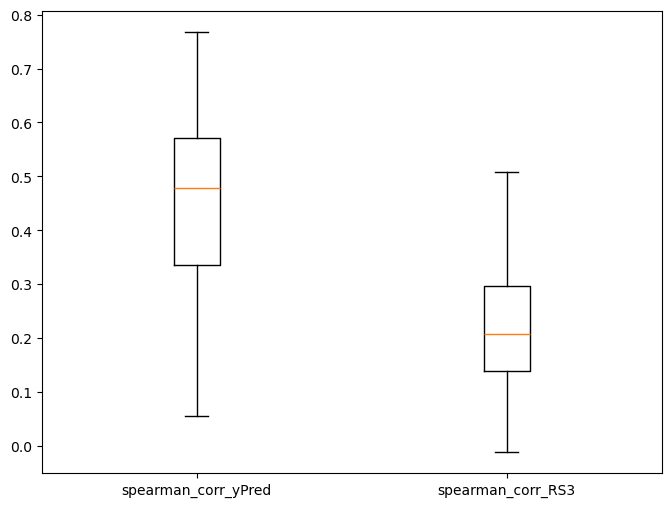

In [17]:
# Plot the boxplot of Spearman correlations
plt.figure(figsize=(8, 6))
plt.boxplot(spearman_df[['spearman_corr_yPred', 'spearman_corr_RS3']], 
            labels=['spearman_corr_yPred', 'spearman_corr_RS3'])
# test is 67% (44% guide) gene in nunez, 30% gene (55% guide)in inhouse, 3% gene (5% guide) in gilbert

In [18]:
from scipy.stats import mannwhitneyu

stat, p_value = mannwhitneyu(spearman_df['spearman_corr_yPred'], 
                             spearman_df['spearman_corr_RS3'], alternative='greater')
p_value


8.729592812510862e-18

In [19]:
spearman_df_underperforming = spearman_df[spearman_df.spearman_corr_yPred < spearman_df['spearman_corr_yPred'].quantile(0.25)]

In [20]:
spearman_df[spearman_df['spearman_corr_yPred'] < spearman_df['spearman_corr_RS3']]

,Target_Gene_Symbol,spearman_corr_yPred,spearman_corr_RS3
7,CARF,0.209748,0.376592
22,EIF4G2,0.252869,0.279233
77,SIRT7,0.103736,0.141507
91,YY1,0.251057,0.274450
92,ZNF131,0.108582,0.154794


In [21]:
import shap

In [22]:
explainer = shap.TreeExplainer(final_model)

In [23]:
shap_values = explainer(Xtest)


In [24]:
shap_df = pd.DataFrame(shap_values.values, columns=Xtest.columns)
mean_shap_values = shap_df.abs().mean().sort_values(ascending=False)
top_features = mean_shap_values.head(10)

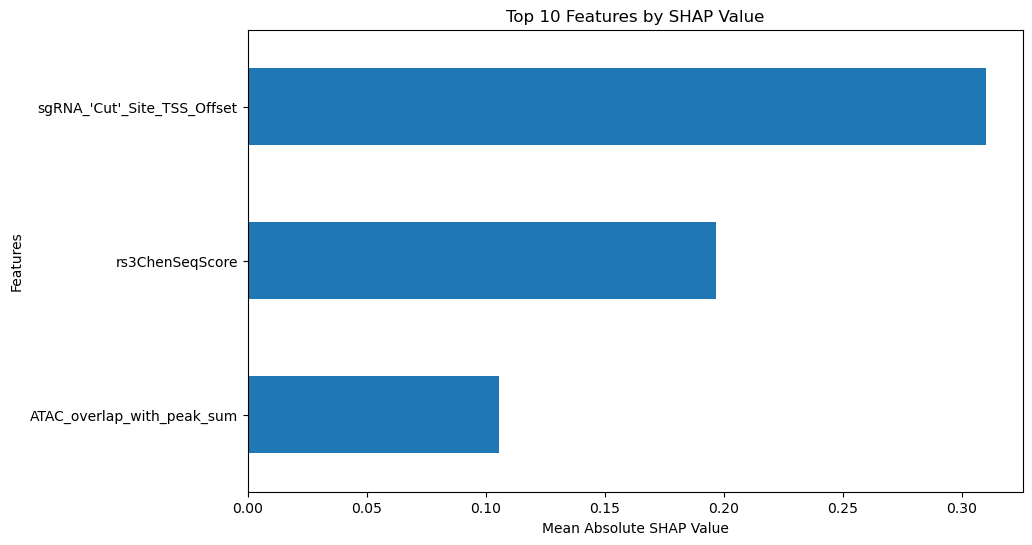

In [25]:
plt.figure(figsize=(10, 6))
top_features.sort_values(ascending=True).plot(kind='barh')
plt.title('Top 10 Features by SHAP Value')
plt.xlabel('Mean Absolute SHAP Value')
plt.ylabel('Features')
plt.show()

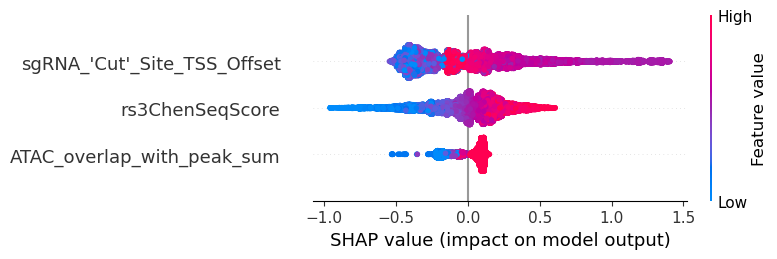

In [26]:
shap.summary_plot(shap_values, Xtest)

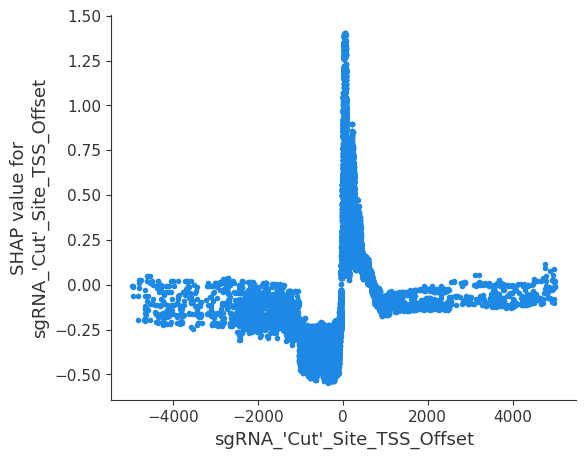

In [27]:
shap.dependence_plot("sgRNA_'Cut'_Site_TSS_Offset", shap_values.values, Xtest, interaction_index=None)


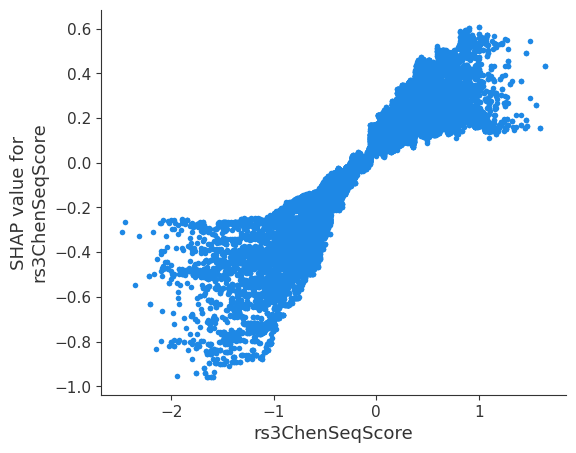

In [28]:
shap.dependence_plot("rs3ChenSeqScore", shap_values.values, Xtest, interaction_index=None)


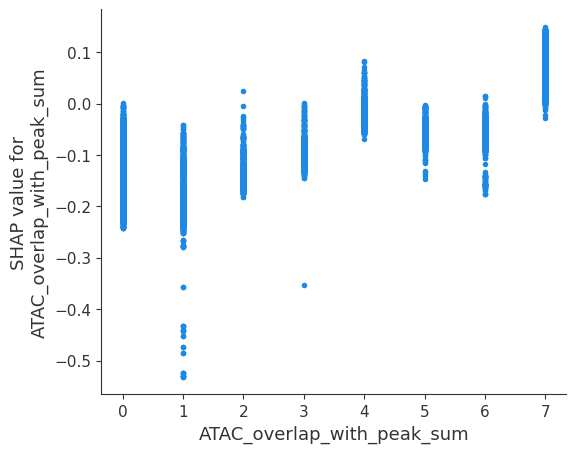

In [31]:
shap.dependence_plot("ATAC_overlap_with_peak_sum", shap_values.values, Xtest, interaction_index=None)


In [46]:
### gene didnt predict well
test_df = pd.read_csv(f'{modelTrainingPath}testData.csv')
test_df_underperformingGene = test_df[test_df.Target_Gene_Symbol.isin(spearman_df_underperforming.Target_Gene_Symbol)]
Xtest_underperformingGene = test_df_underperformingGene.drop(columns=['doubleZscore', 'Target_Gene_Symbol']).copy()
ytest_underperformingGene = test_df_underperformingGene['doubleZscore']


In [47]:
shap_values_underperformingGene = explainer(Xtest_underperformingGene)


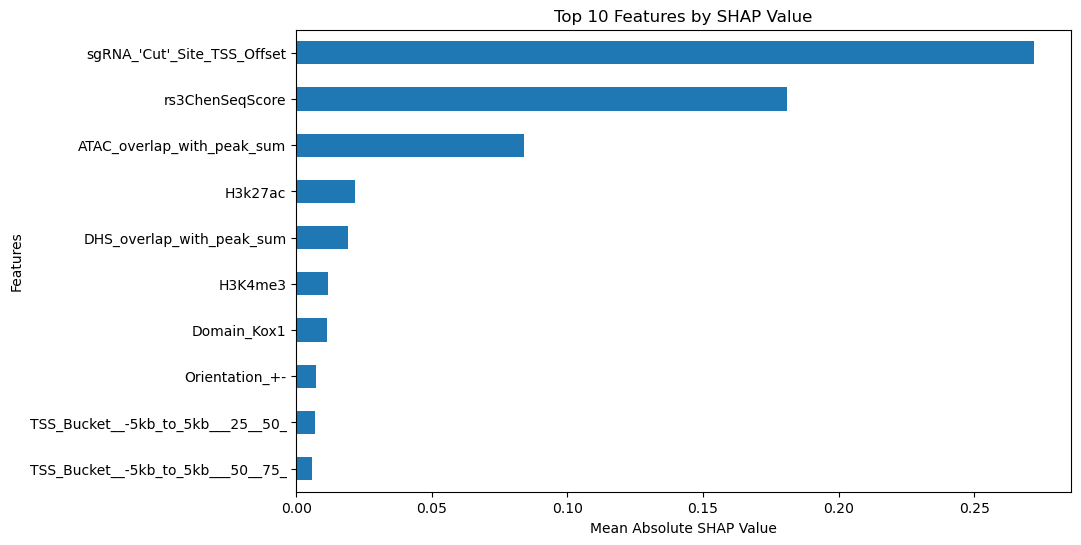

In [50]:
shap_df_underperformingGene = pd.DataFrame(shap_values_underperformingGene.values, columns=Xtest_underperformingGene.columns)
mean_shap_values_underperformingGene = shap_df_underperformingGene.abs().mean().sort_values(ascending=False)
top_features_underperformingGene = mean_shap_values_underperformingGene.head(10)

plt.figure(figsize=(10, 6))
top_features_underperformingGene.sort_values(ascending=True).plot(kind='barh')
plt.title('Top 10 Features by SHAP Value')
plt.xlabel('Mean Absolute SHAP Value')
plt.ylabel('Features')
plt.show()
# this and the figure below goes together 